# Heatmap/Scatterplot

This is basically another modification of the template file that we have used. Basically we just utilize a list of all the groupMetadataID's.
This means we can just run over a list for this and have the same process for the information that we extracted before.
Specifically, the mentors requested that we make a scatterplot/heatmap of the autonomous to manual transitions.

In [2]:
import plotly.express as px
from pandasgui import show
import pandas as pd

# Import plotly.express to utilize map

### List of groupMetadataID


In [114]:
gmIDs = pd.read_csv('./gmIDs.csv')
gmIDList = gmIDs['groupMetadataID']
print(len(gmIDList))
# set to False if data is stored as .csv file.
# otherwise, set to True
queryMetadata = True
queryPose = False
queryChassis = False

59


In [115]:
from boto3.dynamodb.conditions import Key, Attr
import boto3

if queryMetadata:
    # Get the service resource
    dynamodb = boto3.resource('dynamodb')
    # Instantiate a table resource object
    table = dynamodb.Table('ads_passenger_processed_metadata')

In [28]:
#querying for the metadata
metadataFinal = pd.DataFrame()
for gmID in gmIDList:
    res = table.query(
            IndexName='groupMetadataID-index',
            KeyConditionExpression=Key('groupMetadataID').eq(
                f'{gmID}')
        )
    metadata = pd.DataFrame.from_dict(
        pd.json_normalize(res['Items']), orient='columns')
    #print(metadata)
    done = False
    keywords = {
        "IndexName": 'groupMetadataID-index',
        "KeyConditionExpression": Key('groupMetadataID').eq(
            f'{gmID}')
    }
    while not done:
        try: 
            leek = res["LastEvaluatedKey"]
            keywords["ExclusiveStartKey"] = leek
            res = table.query(**keywords)
            tmpDF = pd.DataFrame.from_dict(
                pd.json_normalize(res['Items']), orient='columns')
            metadata = pd.concat([metadata, tmpDF])
        except KeyError:
            metadataFinal = pd.concat([metadataFinal, metadata])
            print(f"done querying for {gmID}")
            done = True

done querying for 2bc6ebb8-a529-11ee-88ec-eb6a8d5269b4
done querying for 8fa6fe80-c869-11ee-a7fc-dd032dba19e8
done querying for 47561998-d9c3-11ee-a158-97f8443fd730


In [60]:
#metadataFinal
unique_df = metadataFinal.drop_duplicates(subset=['groupMetadataID'], keep='first')
unique_df = unique_df.reset_index(drop=True)
unique_df.columns

Index(['dataType', 'vehicleID', 'insertDateTime', 'time', 'driver', 'topics',
       'msgnum', 'headerSize', 'foldername', 'filename', 'groupMetadataID',
       'endTime', '_id', 'experimentID', 'other.Weather', 'other.Map',
       'other.Notes', 'Route', 'Unix Time', 'operator', 'other.Objective',
       'other.MapVersion', 'other.Weather_Lighting',
       'other.Weather_Precipitation', 'other.StackVersion'],
      dtype='object')

In [82]:
#get single column for weather, etc
mdMerger = pd.DataFrame()
for index, row in unique_df.iterrows():
    if pd.notna(row['other.Weather_Lighting']):
        unique_df.at[index, 'other.Weather'] = str(row['other.Weather_Lighting']) + " ," + str(row['other.Weather_Precipitation'])
        unique_df.at[index, 'other.Map'] = str(row['Route']).lower()
mdMerger = unique_df[['groupMetadataID', 'vehicleID', 'other.Weather', 'other.Map', 'other.Notes']]

Redefining table towards regular passenger processed table

In [68]:
from boto3.dynamodb.conditions import Key, Attr
import boto3

if queryPose or queryChassis:
    # Get the service resource
    dynamodb = boto3.resource('dynamodb')
    # Instantiate a table resource object
    table = dynamodb.Table('ads_passenger_processed')

### Querying best_pose data if specified to do so; look for csv's if otherwise

In [92]:
poseList = []
for gmID in gmIDList:
    if queryPose:
        # query for the bestPosData
        res = table.query(
            IndexName='topic-index',
            KeyConditionExpression=Key('topic').eq(
                '/apollo/sensor/gnss/best_pose'),
            ProjectionExpression="groupMetadataID, #t, solStatus, solType, latitudeStdDev, longitudeStdDev, heightStdDev, numSatsInSolution, differentialAge, solutionAge, latitude, longitude",
            Limit=1500,
            ExpressionAttributeNames={'#t': 'time'},
            FilterExpression=Key('groupMetadataID').eq(f'{gmID}')
    
        )
        df_pose = pd.DataFrame.from_dict(
            pd.json_normalize(res['Items']), orient='columns')
        done = False
        leek = res["LastEvaluatedKey"]
        keywords = {
            "IndexName": 'topic-index',
            "KeyConditionExpression": Key('topic').eq(
                '/apollo/sensor/gnss/best_pose'),
            "ProjectionExpression": "groupMetadataID, #t, solStatus, solType, heightStdDev, numSatsInSolution, differentialAge, solutionAge, latitude, longitude, latitudeStdDev, longitudeStdDev",
            "Limit": 1500,
            "ExpressionAttributeNames": {'#t': 'time'},
            "FilterExpression": Key('groupMetadataID').eq(f'{gmID}')
        }
        while not done:
            try:
                leek = res["LastEvaluatedKey"]
                keywords["ExclusiveStartKey"] = leek
                res = table.query(**keywords)
                tmpDF = pd.DataFrame.from_dict(
                    pd.json_normalize(res['Items']), orient='columns')
                df_pose = pd.concat([df_pose, tmpDF])
            except KeyError:
                print(f"done querying for {gmID}")
                # df.to_csv(f"best_pose_58263e34-a45c-11ee-88ec-eb6a8d5269b4.csv")
                done = True
    
        s = "./newTemplateTest/best_pose_" + gmID + ".csv"
        df_pose.to_csv(s)

    df_pose = pd.read_csv(f"./newTemplateTest/best_pose_{gmID}.csv")
    poseList.append(df_pose)
print(len(poseList))
print(poseList[0])

3
      Unnamed: 0                 time  heightStdDev  longitudeStdDev  \
0              0  1696267162048124370      0.049976         0.012680   
1              1  1696267073040116005      0.029685         0.009081   
2              2  1696266836042326589      0.693366         0.486654   
3              3  1696265878044528530      0.782980         0.258845   
4              4  1696265453037847443      0.026612         0.008756   
...          ...                  ...           ...              ...   
1842          32  1696266555040082973      0.029087         0.008109   
1843          33  1696267012048560926      0.043891         0.009359   
1844           0  1696266270039275433      0.052966         0.012362   
1845           1  1696266275041982941      0.062134         0.014854   
1846           2  1696266468040001493      0.028091         0.010095   

                           groupMetadataID  latitudeStdDev  differentialAge  \
0     2bc6ebb8-a529-11ee-88ec-eb6a8d5269b4        0.01

### Querying chassis data if specified to do so; go to file location specified and use csv's if not

In [94]:
#making a list of dataframes once we get all the csv read
chassisList = []
for gmID in gmIDList:
    if queryChassis:
        res = table.query(
            IndexName='topic-index',
            KeyConditionExpression=Key('topic').eq('/apollo/canbus/chassis'),
            FilterExpression=Key('groupMetadataID').eq(f'{gmID}')
        )
        df = pd.DataFrame.from_dict(
            pd.json_normalize(res['Items']), orient='columns')
        done = False
        leek = res["LastEvaluatedKey"]
        keywords = {
            "IndexName": 'topic-index',
            "KeyConditionExpression": Key('topic').eq('/apollo/canbus/chassis'),
            "FilterExpression": Key('groupMetadataID').eq(f'{gmID}')
        }
        while not done:
            try:
                leek = res["LastEvaluatedKey"]
                keywords["ExclusiveStartKey"] = leek
                res = table.query(**keywords)
                tmpDF = pd.DataFrame.from_dict(
                    pd.json_normalize(res['Items']), orient='columns')
                df = pd.concat([df, tmpDF])
    
            except KeyError:
                print(f"done querying for {gmID}")
                done = True
    
        s = f"./x/{gmID}.csv"
        df.to_csv(s)
    #read csv
    chassisFrame = pd.read_csv(f"./x/{gmID}.csv")
    #append csv to the list
    chassisList.append(chassisFrame)
print(len(chassisList))
print(chassisList[0].shape)

3
(92224, 32)


In [95]:
for i in range(0, len(chassisList)):
    chassisList[i] = chassisList[i].sort_values('time')
    # reduce df to only time and drivingMode
    chassisList[i] = chassisList[i][["time", "drivingMode"]]
    # function to tell us what state transition it is
    
    
    def getState(old, new):
        if old == "COMPLETE_AUTO_DRIVE" and new == "COMPLETE_MANUAL":
            return "A->M"
        elif old == "COMPLETE_AUTO_DRIVE" and new == "EMERGENCY_MODE":
            return "A->M"
        elif old == "COMPLETE_MANUAL" and new == "COMPLETE_AUTO_DRIVE":
            return "M->A"
        elif old == "EMERGENCY_MODE" and new == "COMPLETE_AUTO_DRIVE":
            return "M->A"
        else:
            return "NONE"
    
    
    # we shift the drivingMode column down by 1
    chassisList[i]["shift"] = chassisList[i]["drivingMode"].shift()
    # create transition field
    chassisList[i]['transition'] = (chassisList[i]["drivingMode"] != chassisList[i]["shift"])
    # set Transition type to NONE for all
    chassisList[i]['transitionType'] = "NONE"
    # Set first transition to False, since it was auto True
    chassisList[i].loc[0, 'transition'] = False
    # print(pts['transition'])
    # Show counts for transitions
    #print(pts['transition'].value_counts())
    # iterate over all rows and find the ones where transition is true. Then we compare shift and dM to see what
    # transition Type we have.
    for index, row in chassisList[i].iterrows():
        if chassisList[i]['transition'][index] == True:
            old = chassisList[i]['shift'][index]
            new = chassisList[i]['drivingMode'][index]
            chassisList[i].loc[index, "transitionType"] = getState(old, new)
    #print(pts['transitionType'].value_counts())
    chassisList[i] = chassisList[i][['time', 'drivingMode', 'transition', 'transitionType']]
    chassisList[i] = chassisList[i].sort_values('time')
    chassisList[i]['time'] = chassisList[i]['time'].astype(float)
    chassisList[i]['time'] = chassisList[i]['time'].astype('datetime64[ns]')
    chassisList[i]['time'] = chassisList[i]['time'].astype('datetime64[s]')
    #print(chassisList[i][['time']])

In [101]:
finalDF = pd.DataFrame()
print(len(poseList))
for i in range(0,len(poseList)):
    bestPos = poseList[i].copy()
    bestPos = bestPos.sort_values('time')
    bestPos['time'] = bestPos['time'].astype(float)
    bestPos['time'] = bestPos['time'].astype('datetime64[ns]')
    bestPos['time'] = bestPos['time'].astype('datetime64[s]')
    bestPos = bestPos[['groupMetadataID', 'time', 'latitude', 'longitude']]
    #print(bestPos['time'])
    #print(chassisList[i]['time'])
    merged_df = pd.merge(chassisList[i], bestPos, on='time')
    merged_df = merged_df.drop_duplicates(subset = ['time', 'transitionType'])
    #merged_df = pd.merge(merged_df, mdMerger, on='groupMetadataID')
    #merged_df = merged_df[(merged_df['transitionType'] == 'A->M')]
    #remove all NONE transition columns
    finalDF = pd.concat([finalDF, merged_df])
#show(finalDF)

3


In [103]:
finalDF = pd.merge(finalDF, mdMerger, on='groupMetadataID')

In [112]:
finalDF.rename(columns={"other.Weather":"weather", "other.Map":"route", "other.Notes":"driverNotes"})

time      drivingMode  transition transitionType  \
0    2023-10-02 16:48:43  COMPLETE_MANUAL       False           NONE   
1    2023-10-02 16:48:44  COMPLETE_MANUAL       False           NONE   
2    2023-10-02 16:48:45  COMPLETE_MANUAL       False           NONE   
3    2023-10-02 16:48:46  COMPLETE_MANUAL       False           NONE   
4    2023-10-02 16:48:47  COMPLETE_MANUAL       False           NONE   
...                  ...              ...         ...            ...   
5788 2023-07-27 18:52:31   EMERGENCY_MODE       False           NONE   
5789 2023-07-27 18:52:32   EMERGENCY_MODE       False           NONE   
5790 2023-07-27 18:52:33   EMERGENCY_MODE       False           NONE   
5791 2023-07-27 18:52:34   EMERGENCY_MODE       False           NONE   
5792 2023-07-27 18:52:35   EMERGENCY_MODE       False           NONE   

                           groupMetadataID   latitude  longitude   vehicleID  \
0     2bc6ebb8-a529-11ee-88ec-eb6a8d5269b4  39.334251 -82.132322  OUPacifica   
1     2bc6ebb8-a529-11ee-88ec-eb6a8d5269b4  39.334337 -82.132398  OUPacifica   
2     2bc6ebb8-a529-11ee-88ec-eb6a8d5269b4  39.334429 -82.132482  OUPacifica   
3     2bc6ebb8-a529-11ee-88ec-eb6a8d5269b4  39.334532 -82.132578  OUPacifica   
4     2bc6ebb8-a529-11ee-88ec-eb6a8d5269b4  39.334643 -82.132685  OUPacifica   
...                                    ...        ...        ...         ...   
5788  47561998-d9c3-11ee-a158-97f8443fd730  39.332704 -82.131115        Van1   
5789  47561998-d9c3-11ee-a158-97f8443fd730  39.332603 -82.130982        Van1   
5790  47561998-d9c3-11ee-a158-97f8443fd730  39.332503 -82.130848        Van1   
5791  47561998-d9c3-11ee-a158-97f8443fd730  39.332403 -82.130714        Van1   
5792  47561998-d9c3-11ee-a158-97f8443fd730  39.332303 -82.130581        Van1   

                      weather                route  \
0            80 F, clear, dry  ohio_athens_blue_v3   
1            80 F, clear, dry  ohio_athens_blue_v3   
2            80 F, clear, dry  ohio_athens_blue_v3   
3            80 F, clear, dry  ohio_athens_blue_v3   
4            80 F, clear, dry  ohio_athens_blue_v3   
...                       ...                  ...   
5788  Clear ,No precipitation                 blue   
5789  Clear ,No precipitation                 blue   
5790  Clear ,No precipitation                 blue   
5791  Clear ,No precipitation                 blue   
5792  Clear ,No precipitation                 blue   

                               driverNotes  
0     20mph on Court street feels too fast  
1     20mph on Court street feels too fast  
2     20mph on Court street feels too fast  
3     20mph on Court street feels too fast  
4     20mph on Court street feels too fast  
...                                    ...  
5788                                   NaN  
5789                                   NaN  
5790                                   NaN  
5791                                   NaN  
5792                                   NaN  

[5793 rows x 11 columns]

### Mapping


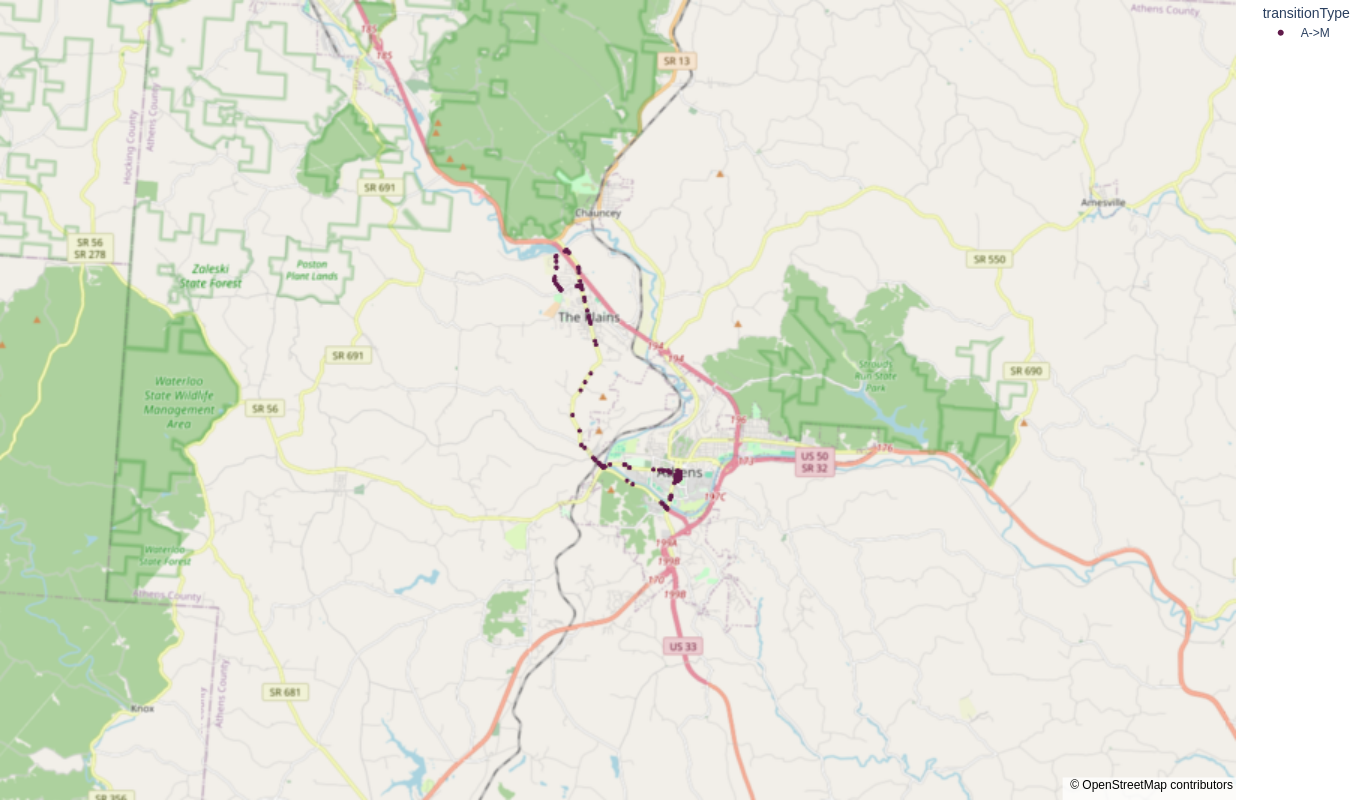

True

In [104]:
from dash import Dash, dcc, html
import webbrowser

# Define your map with your dataframe name first and keep everything else the same
fig = px.scatter_mapbox(finalDF, lat="latitude", lon="longitude",
                        hover_data=["time", "drivingMode", "transitionType"], color="transitionType", zoom=11, height=800, width=1200,
                        color_discrete_sequence=[
                            "#601A4A",
                            "#63ACBE",
                            "#EE442F",
                        ]
                        )

# Layout settings
fig.update_layout(
    mapbox_style="open-street-map",
    margin={"r": 0, "t": 0, "l": 0, "b": 0},
)

# Display the map
fig.show()
app = Dash()
app.layout = html.Div([
    dcc.Graph(figure=fig)
])

# Turn off reloader if inside Jupyter
app.run_server(debug=True, use_reloader=False)
webbrowser.open('http://127.0.0.1:8050/', new=0)  # Go to example.com

In [13]:
fig.write_image("disengagementMap2.png", engine="kaleido")

In [ ]:
# Define your map with your dataframe name first and keep everything else the same
fig2 = px.scatter_mapbox(merged_df, lat="latitude",
                         lon="longitude",
                         hover_data=["time", "drivingMode", "transitionType"],
                         color="drivingMode",
                         zoom=14,
                         height=700,
                         width=1000,
                         color_discrete_map={
                             "COMPLETE_MANUAL": "#601A4A",
                             "COMPLETE_AUTO_DRIVE": "#63ACBE",
                             "EMERGENCY_MODE": "#EE442F",
                         }

                         )

# Layout settings
fig2.update_layout(mapbox_style="open-street-map")
fig2.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})

# Display the map
fig2.show()

In [34]:
from dash import Dash, dcc, html
import webbrowser

fig4 = px.scatter_mapbox(merged_df, lat="latitude",
                         lon="longitude",
                         hover_data=["time", "drivingMode", "transitionType"],
                         color="drivingMode",
                         zoom=14,
                         height=850,
                         width=1500,
                         color_discrete_map={
                             "COMPLETE_MANUAL": "#601A4A",
                             "COMPLETE_AUTO_DRIVE": "#63ACBE",
                             "EMERGENCY_MODE": "#EE442F",
                         })

# Layout settings
fig4.update_layout(mapbox_style="open-street-map")
fig4.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})

app = Dash()
app.layout = html.Div([
    dcc.Graph(figure=fig4)
])

# Turn off reloader if inside Jupyter
app.run_server(debug=True, use_reloader=False)
webbrowser.open('http://127.0.0.1:8050/', new=0)  # Go to example.com

True

### Plotting


In [30]:
fig3 = px.line(merged_df, x='time', y='drivingMode',
               title='Times at Which Transitions Occur')
fig3.update_xaxes(rangeslider_visible=True)
fig3.show()